# Reinforcement Learning Homework

Before you turn this notebook in, make sure everything runs as expected. First, **restart the kernel** (in the menu bar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menu bar, select Cell $\rightarrow$ Run All). You can also perform the two operations in one step (in the menu bar, select Kernel $\rightarrow$ Restart & Run All).

Make sure you fill in any place (or anywhere that you want in the code) that says `YOUR CODE HERE` or "YOUR ANSWER HERE", and remove every line containing the expression: "raise ..." (if you leave such a line your code will not run). This is a reminder for you to complete all parts of the notebook. You can also send an incomplete notebook, but please remove all 'raise'-lines in any case.

You are not required to modify the code only where the line `YOUR CODE HERE` appears. In fact you can modify the given function and code as you want. Those are just reminders.

Do not remove any cell from the notebook you downloaded. You can add any number of cells (and remove them if not more necessary). 

## IMPORTANT: make sure to rerun all the code from the beginning to obtain the results for the final version of your code, since this is the way we will do it before evaluating your notebook!

Fill in your name and ID number (matricola) below:

In [1]:
NAME = 'Giulio Savian'
ID_number = int('2028639')

import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

---

# First Homework - Multi-Armed Bandits and Dynamic Programming

The present homework contains 2 exercises, one related to Multi-Armed Bandit problem and the other to Dynamic Programming.

- Delivery date: 2021/20/21

- Submission deadline: 2021/11/12 (23:59)

# Nonstationary Multi-Armed Bandits

The first part of the homework deals with the Multi Armed Bandit Problem.
In particular, the 10-armed testbed environment is exploited in order to understand what happens when dynamics are introduced in the arm rewards.
In order to complete the following exercise you will have to **modify** the 10-armed testbed environment in such a way that the mean values $q(a)$ of all the arms **start out equal** and then take **independent random walks**. This means that we will have:

$$ q_0(a) = 0, \qquad \forall a \in \mathcal{A}$$

$$q_t(a) = q_{t-1}(a) + w_{t-1}, \qquad \forall a \in \mathcal{A}, \qquad \textrm{where} \quad w_t \sim \mathcal{N}(0, \sigma^2)$$

Assume $\sigma = 0.1$.

Compare the performance of two different instances of the **Epsilon-Greedy algorithm**, one using **sample averages**, and the other using a **constant step size** $\alpha = 0.1$.
Plot the **average reward**, the **cumulative average reward**, and the **average percentage of optimal actions**: use $\epsilon=0.1$ and average over $500 \ \texttt{runs}$ for $5000 \ \texttt{steps}$.

##  IMPORTANT: Make sure that **before** the cell saying 'HERE ENDS THE FIRST EXERCISE' you have a variable called 'rewards' which is a numpy nd-array containing the average (over different runs) rewards of the two algorithms! To check this, you can run the assert statement in the cell: if it does not raise an error, you should be fine.

In [2]:
## Credits and imports

#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Tian Jun(tianjun.cpp@gmail.com)                                #
# 2016 Artem Oboturov(oboturov@gmail.com)                             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, trange
import seaborn as sns
from scipy.stats import poisson

For your convenience, the code discussed in the first "tutorial lesson" is reported below. Feel free to modify the code as you wish in order to achieve the required result.


100%|██████████| 500/500 [01:37<00:00,  5.13it/s]


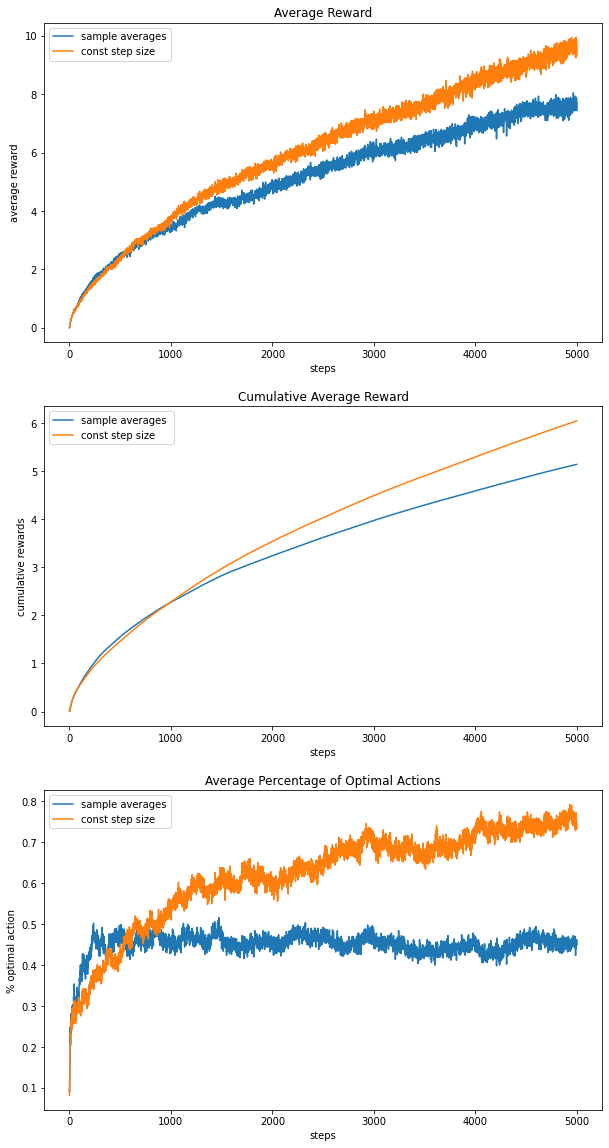

In [3]:
class Bandit:
    # @k_arm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @initial: initial estimation for each action
    # @step_size: constant step size for updating estimations
    # @sample_averages: if True, use sample averages to update estimations instead of constant step size
    # @UCB_param: if not None, use UCB algorithm to select action
    # @gradient: if True, use gradient based bandit algorithm
    # @gradient_baseline: if True, use average reward as baseline for gradient based bandit algorithm
    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1, sample_averages=False, UCB_param=None,
                 gradient=False, gradient_baseline=False, true_reward=0.,sigma = 0.1):
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCB_param = UCB_param
        self.gradient = gradient
        self.gradient_baseline = gradient_baseline
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.initial = initial
        self.sigma = sigma

    def reset(self):
        # real reward for each action
        self.q_true = np.zeros(self.k)#self.true_reward + np.random.randn(self.k)
        
        # estimation for each action
        self.q_estimation = np.zeros(self.k) + self.initial

        # # of chosen times for each action
        self.action_count = np.zeros(self.k)

        self.best_action = np.random.choice(self.indices) 

        self.time = 0

    # get an action for this bandit
    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices) 

        if self.UCB_param is not None:
            UCB_estimation = self.q_estimation + \
                self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
            q_best = np.max(UCB_estimation)
            return np.random.choice(np.where(UCB_estimation == q_best)[0])

        if self.gradient:
            exp_est = np.exp(self.q_estimation)
            self.action_prob = exp_est / np.sum(exp_est)
            return np.random.choice(self.indices, p=self.action_prob)

        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    def random_walks(self):
      self.q_true += self.sigma*np.random.randn(self.k)
      self.best_action = np.argmax(self.q_true)
    
    # take an action, update estimation for this action
    def step(self, action):
        # generate the reward under N(real reward, 1)
        reward = self.sigma*np.random.randn() + self.q_true[action] # MY CODE: added the non stationarity
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time 

        if self.sample_averages:
            # update estimation using sample averages
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]

        elif self.gradient:
            one_hot = np.zeros(self.k)
            one_hot[action] = 1
            if self.gradient_baseline:
                baseline = self.average_reward
            else:
                baseline = 0
            self.q_estimation += self.step_size * (reward - baseline) * (one_hot - self.action_prob)
        else:
            # update estimation with constant step size
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        return reward

def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        for r in trange(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
                bandit.random_walks()

    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    reward1 = mean_rewards[0]
    reward2 = mean_rewards[1]

    cumulative_reward = np.zeros(mean_rewards.shape)
    cumulative_reward[0] = np.cumsum(reward1)
    for i in range(0,cumulative_reward.shape[1]):
      cumulative_reward[0,i] = cumulative_reward[0,i] / (i+1)
    cumulative_reward[1] = np.cumsum(reward2)
    for i in range(0,cumulative_reward.shape[1]):
      cumulative_reward[1,i] = cumulative_reward[1,i] / (i+1)

    return mean_best_action_counts, mean_rewards, cumulative_reward

# Recall you have to modify the environment above!
# YOUR CODE HERE

bandits = []
bandits.append(Bandit(epsilon = 0.1, initial=0, step_size=0.1, sample_averages=True))
bandits.append(Bandit(epsilon = 0.1, initial=0, step_size=0.1, sample_averages=False))

mean_best_action_counts, rewards, cumulative_mean_reward = simulate(500,5000,bandits)


# Code for the figures
# YOUR CODE HERE

plt.figure(figsize=(10, 20))
alpha = 0.1

plt.subplot(3, 1, 1)
plt.plot(rewards[0], label='sample averages')
plt.plot(rewards[1], label='const step size')
plt.xlabel('steps')
plt.ylabel('average reward')
plt.title('Average Reward')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(cumulative_mean_reward[0], label='sample averages ')
plt.plot(cumulative_mean_reward[1], label='const step size')
plt.xlabel('steps')
plt.ylabel('cumulative rewards')
plt.title('Cumulative Average Reward')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(mean_best_action_counts[0], label='sample averages')
plt.plot(mean_best_action_counts[1], label='const step size')
plt.xlabel('steps')
plt.ylabel('% optimal action')
plt.title('Average Percentage of Optimal Actions')
plt.legend()

plt.show()

In [4]:
# HERE ENDS THE FIRST EXERCISE
assert rewards.shape == (2, 5000)

Comment your results in the cell below. Which algorithm performed best? With respsect to which metric? Why? [~15 lines]

From the plots we can notice that the Epsilon-Greedy algorithm using constant step size  $\alpha=0.1$ has better performance w.r.t. the sample averages. All the three plots highlight this, using constant step size the algorithm is able to reach higher value mean rewards. The cumulative average rewars of the sample averages remains bigger as well. The percentage of optimal action is  
twice that of the sample avaerages(0.8 in comparison of 0.4 of s.a.).\
The differences in the algorithms are due to the weights applayed to the rewards.
In a non-stationary enviroment, where the bandit is changing over time, is fondamental to weight recent rewards more heavily than long-past one. In this way we take care more about recent rewards, like in the constant step size algorithm.\
In this case, the sum of all the rewards is $(1-\alpha)^k + \sum_{i=0}^k \alpha(1-\alpha)^k-i = 1 $ so that the weight decays exponentially according to the exponent on $1-\alpha$, implicating to decrease any new reward 'Ri' according o that exponent  (1−α) .\
Using this algorithm we are able to satisfy only condition '1', below, and the estimates never completely converge but continue to vary in response to the most recently received rewards.\
Conditions required to assure convergence with probability 1:\
\begin{equation}
  1) \sum_{i=0}^\infty \alpha_k(a) = \infty \quad \textrm{and} \quad   2)  \sum_{i=0}^\infty \alpha_k^2(a) < \infty 
\end{equation}
1) guarantee that the steps are large enough to eventually overcome any initial conditions or random fluctuations. \
2) guarantees that eventually the steps become small enough to assure
convergence.\
Sometimes it is convenient to vary the step-size parameter from step to
step $\alpha_k(a) = \frac{1}{k}$. In this way both convergence conditions can be met.




# Jack against the nationwide company

The second part of the homework consists of a modification of the Jack's Car Rental problem discussed during the second "Tutorial Lecture".
One of Jack’s employees at the first location rides a bus home each night and lives near the second location. She is happy to **shuttle one car to the second location for free**, while each additional car costs the usual $2\$$. Moreover, the nationwide car rental company has changed its policy on parking spaces: for each location now Jack can only park up to 10 vehicles free of charge. **If more than 10 cars are kept overnight at a location, then an additional cost of $4\$$ must be incurred** to use a second parking lot (independent of how many cars are kept there). The car rental company charges Jack with the additional parking lots price first thing in the morning, **before any possible moving of cars**.
In order to fulfill the exercise requirements, you need to **modify and solve** the new instance of the Jack's car rental problem with a **Value Iteration** algorithm.
Generate a subplot with six cells as the one seen in the "Tutorial Lecture" with the figures of 5 policies at different iterations: #0, #7, #14, #21, and the last (optimal!) one. In the sixth box plot the optimal value-function.
Use $\texttt{constant}$_$\texttt{returned}$_$\texttt{cars}$ = **True**.

##  IMPORTANT: Make sure that **before** the cell saying 'HERE ENDS THE FIRST EXERCISE' you have a variable called 'policy' which is a numpy nd-array containing the optimal action for each pair of states, as in the notebook of the second "Tutorial Lecture"! To check this, you can run the assert statement in the cell: if it does not raise an error, you should be fine.

max value change 331.1208441900402
max value change 144.73923246766776
max value change 93.91174142579194
max value change 64.11795222877242
max value change 47.78230861300071
max value change 37.74774410716887
max value change 29.75159023775626
max value change 23.502850187007994
max value change 18.62257724934193
max value change 15.222258970445125
max value change 12.883785859537397
max value change 10.877223433455583
max value change 9.201857152502214
max value change 7.7789360267776715
max value change 6.571748621010272
max value change 5.54984239847073
max value change 4.685955267028419
max value change 3.9593677514499177
max value change 3.4025273503529547
max value change 2.9136135296431576
max value change 2.4916378861432236
max value change 2.1296319770466994
max value change 1.819789586757679
max value change 1.555024552459713
max value change 1.330080877699686
max value change 1.137826385235087
max value change 0.9733683603777763
max value change 0.8326729645328328
max valu

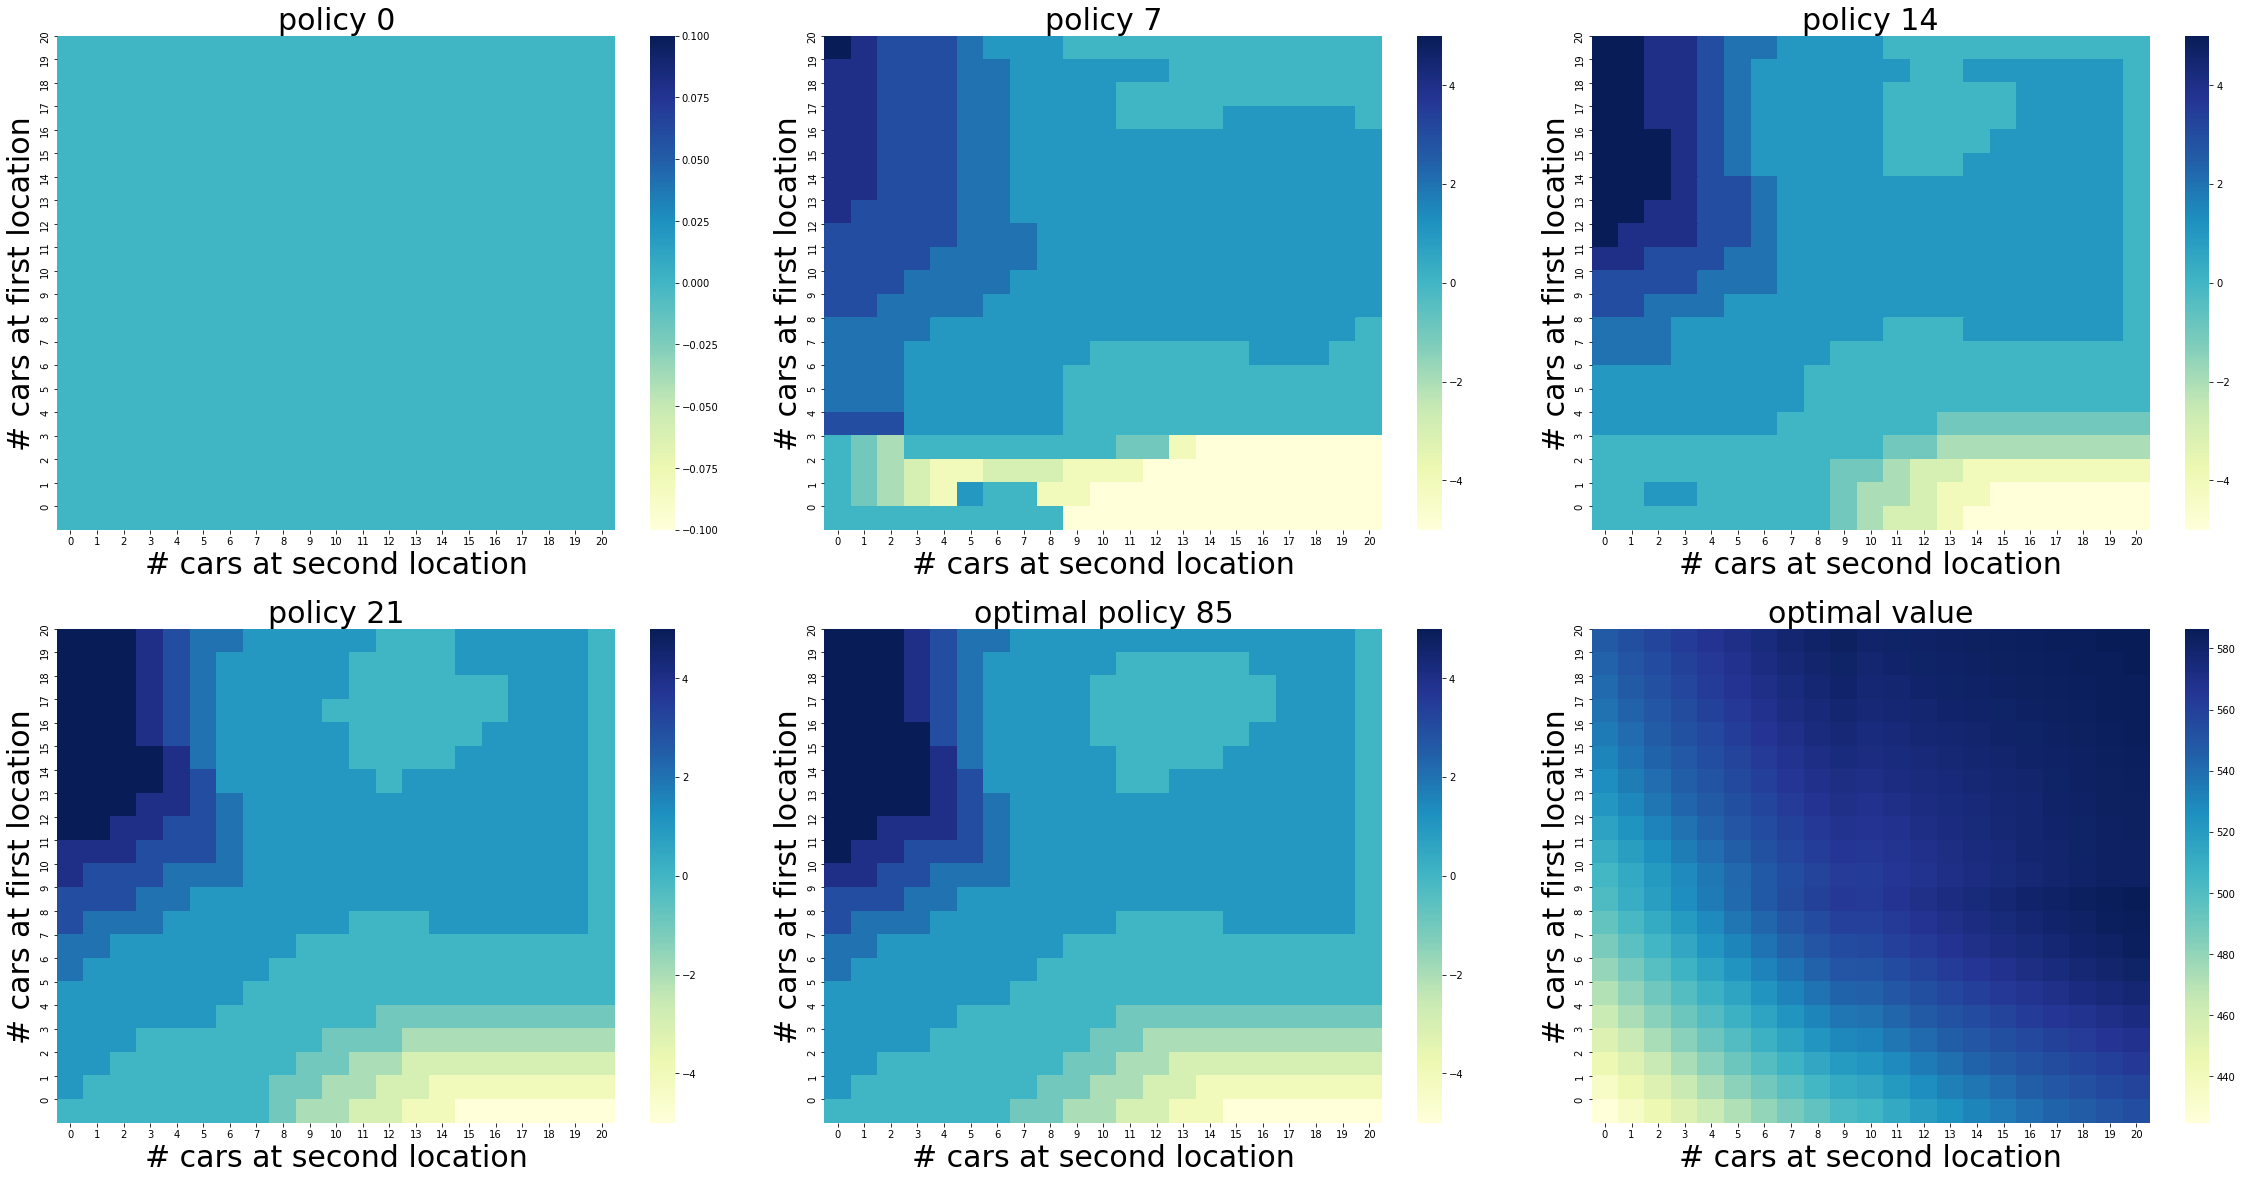

In [5]:
# maximum # of cars in each location
MAX_CARS = 20

# maximum # of cars to move during night
MAX_MOVE_OF_CARS = 5

# expectation for rental requests in first location
RENTAL_REQUEST_FIRST_LOC = 3

# expectation for rental requests in second location
RENTAL_REQUEST_SECOND_LOC = 4

# expectation for # of cars returned in first location
RETURNS_FIRST_LOC = 3

# expectation for # of cars returned in second location
RETURNS_SECOND_LOC = 2

DISCOUNT = 0.9

# credit earned by a car
RENTAL_CREDIT = 10

# cost of moving a car
MOVE_CAR_COST = 2

#cost parking lot
PARCKING_LOT_COST = 4                          #MY CODE

# all possible actions
actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS + 1)

# An upper bound for poisson distribution
# If n is greater than this value, then the probability of getting n is truncated to 0
POISSON_UPPER_BOUND = 11

# Probability for poisson distribution
# @lam: lambda should be less than 10 for this function
poisson_cache = dict()

def poisson_probability(n, lam):
    global poisson_cache
    key = n * 10 + lam
    if key not in poisson_cache:
        poisson_cache[key] = poisson.pmf(n, lam)
    return poisson_cache[key]

def expected_return(state, action, state_value, constant_returned_cars):
    """
    @state: [# of cars in first location, # of cars in second location]
    @action: positive if moving cars from first location to second location,
            negative if moving cars from second location to first location
    @stateValue: state value matrix
    @constant_returned_cars:  if set True, model is simplified such that
    the # of cars returned in daytime becomes constant
    rather than a random value from poisson distribution, which will reduce calculation time
    and leave the optimal policy/value state matrix almost the same
    """
    # initialize total return
    returns = 0.0

    # cost for moving cars
    
    # Recall you have to modify the environment below!
    # YOUR CODE HERE

    #check if parcking lots full  #MY CODE
    if state[0] >= 10:                                                           
      first_parcking_lot = 1  
    else:
      first_parcking_lot = 0                                                    
    if state[1] >= 10:                                                           
      second_parcking_lot = 1                                                   
    else:
      second_parcking_lot = 0 

    # cost for parking lot #MY CODE 
    returns -= PARCKING_LOT_COST * (first_parcking_lot + second_parcking_lot)  

    #if we have to shuttle one car then the employer shuttle it for free  #MY CODE
    shuttle_free = 0                        
    if action > 0 and action < 20:                                                              
        shuttle_free = 1    

    returns -= MOVE_CAR_COST * abs(action - shuttle_free)  #we remove che cost of moving a car                                                
     
    # moving cars
    NUM_OF_CARS_FIRST_LOC = min(state[0] - action, MAX_CARS)
    NUM_OF_CARS_SECOND_LOC = min(state[1] + action, MAX_CARS)


    # go through all possible rental requests
    for rental_request_first_loc in range(POISSON_UPPER_BOUND):
        for rental_request_second_loc in range(POISSON_UPPER_BOUND):
            # probability for current combination of rental requests
            prob = poisson_probability(rental_request_first_loc, RENTAL_REQUEST_FIRST_LOC) * \
                poisson_probability(rental_request_second_loc, RENTAL_REQUEST_SECOND_LOC)

            num_of_cars_first_loc = NUM_OF_CARS_FIRST_LOC
            num_of_cars_second_loc = NUM_OF_CARS_SECOND_LOC

            # valid rental requests should be less than actual # of cars
            valid_rental_first_loc = min(num_of_cars_first_loc, rental_request_first_loc)
            valid_rental_second_loc = min(num_of_cars_second_loc, rental_request_second_loc)

            # get credits for renting
            reward = (valid_rental_first_loc + valid_rental_second_loc) * RENTAL_CREDIT
            num_of_cars_first_loc -= valid_rental_first_loc
            num_of_cars_second_loc -= valid_rental_second_loc

            if constant_returned_cars:
                # get returned cars, those cars can be used for renting tomorrow
                returned_cars_first_loc = RETURNS_FIRST_LOC
                returned_cars_second_loc = RETURNS_SECOND_LOC
                num_of_cars_first_loc = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                num_of_cars_second_loc = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                returns += prob * (reward + DISCOUNT * state_value[num_of_cars_first_loc, num_of_cars_second_loc])
            else:
                for returned_cars_first_loc in range(POISSON_UPPER_BOUND):
                    for returned_cars_second_loc in range(POISSON_UPPER_BOUND):
                        prob_return = poisson_probability(
                            returned_cars_first_loc, RETURNS_FIRST_LOC) * poisson_probability(returned_cars_second_loc, RETURNS_SECOND_LOC)
                        num_of_cars_first_loc_ = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                        num_of_cars_second_loc_ = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                        prob_ = prob_return * prob
                        returns += prob_ * (reward + DISCOUNT *
                                            state_value[num_of_cars_first_loc_, num_of_cars_second_loc_])
    return returns

# This is the parameter of the function in the original code
constant_returned_cars = True

value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))

policy = np.zeros(value.shape, dtype=np.int)

iterations = 0
_, axes = plt.subplots(2, 3, figsize=(40, 20))
plt.subplots_adjust(wspace=0.1, hspace=0.2)
axes = axes.flatten()

# Code for value iteration algorithm and figures
# YOUR CODE HERE

# value iteration (in-place) (we compute the true value of the value function for a specific policy)             #MY CODE ALL BELOW
while True:
    if iterations == 0 or iterations == 7 or iterations == 14 or iterations == 21:
        m = int(iterations/7)
        fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[m]) #plot the policy
        fig.set_ylabel('# cars at first location', fontsize=30)
        fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
        fig.set_xlabel('# cars at second location', fontsize=30)
        fig.set_title('policy {}'.format(iterations), fontsize=30)
    
    old_value = value.copy() #keep estimate of value function since is used in the previus formula V(s')
    # Sweep through all states following the same policy
    for i in range(MAX_CARS + 1):
        for j in range(MAX_CARS + 1):
            action_returns = [] #inizialize empty list

            for action in actions: #iterate for all possible actions (defined at the beggining)
            # if it is a 'legal' action, i.e. I am not trying to move more cars than I have in that location
                if (0 <= action <= i) or (-j <= action <= 0):
                    action_returns.append(expected_return([i, j], action, value, constant_returned_cars)) #return for all the actions
            # fraud against the car rental company ---> lawyers, possible imprisonment, very low reward
                else:
                    action_returns.append(-np.inf) #if not valid action it is set to -infinity

            new_action = actions[np.argmax(action_returns)] #chosing the best action
            new_state_value = max(action_returns) #policy[i, j] is the action in that state
            # in-place update!
            value[i, j] = new_state_value
            policy[i,j] = new_action

    max_value_change = abs(old_value - value).max() #how huch the value function is actually changing
    print('max value change {}'.format(max_value_change))          
    if max_value_change < 1e-4: #termination condition
        print('im breaking')
        break       
    
    iterations += 1

#plot the optimal
fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[-2]) #plot the policy
fig.set_ylabel('# cars at first location', fontsize=30)
fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
fig.set_xlabel('# cars at second location', fontsize=30)
fig.set_title('optimal policy {}'.format(iterations), fontsize=30)

# plot the optimal value function
fig = sns.heatmap(np.flipud(value), cmap="YlGnBu", ax=axes[-1])
fig.set_ylabel('# cars at first location', fontsize=30)
fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
fig.set_xlabel('# cars at second location', fontsize=30)
fig.set_title('optimal value', fontsize=30)


plt.show()

In [6]:
# HERE ENDS THE SECOND EXERCISE
assert policy.shape == (21, 21)

Comment your results in the cell below. Can you give an intuitive explanation for the optimal policy you found? [~15 lines]

We initialize the policy to zero. Using the value iteration in every loop we perform the policy improvement and truncated policy evaluation steps, so that we obtain a better policy, getting closer to the optimal one. In fact, by looking at the plots and proceeding with the iterations the policies are more structured, meaning that is understanding better how to improve the reward. \
The following policies show us that for each number of cars at each location at the end of the day, the number of cars to be moved from the first location to the second (negative numbers indicate transfers from the second location to the first).
Can be seen that, when there are a lot of cars in the first location and few cars in the second we like the action 5, i.e. move five cars from first location to the second one, like in the not modified problem example. But, differently from the last problem is that if the number of cars were similar it was not good to move cars from a location to the other one. Now, due to the modification, the policies plots are different and reflects the problem changes. \
The first change: 'if there is a car available than the employ can shuttle it for free', is reflected in the policy plots through a division in the middle and diagonal between action 0 and 1, this is due since now we have the possibility of moving a car from first location to second for free. Then I will expext that this action will be more frequent exploit, helping to balance the # of cars in each location and taking advantage of the free 'reward'.
The other main change is that 'we have to pay an extra parcking lot price if more than 10 cars are kept overnight at a location', the effect on the optimal policy are not predominant, but we can notice a spot betwin state [0] = 14-19 and state [1] = 10-16 where we prefare to take the action 0 instead of 1. FOr that change there isn't a intuitive solution, since my idea would have been to move the car if the parking spot has a number major than 10, but this is not evident. We can understand better the changing on the policy by considering separately the two modifications and running the two cases.

